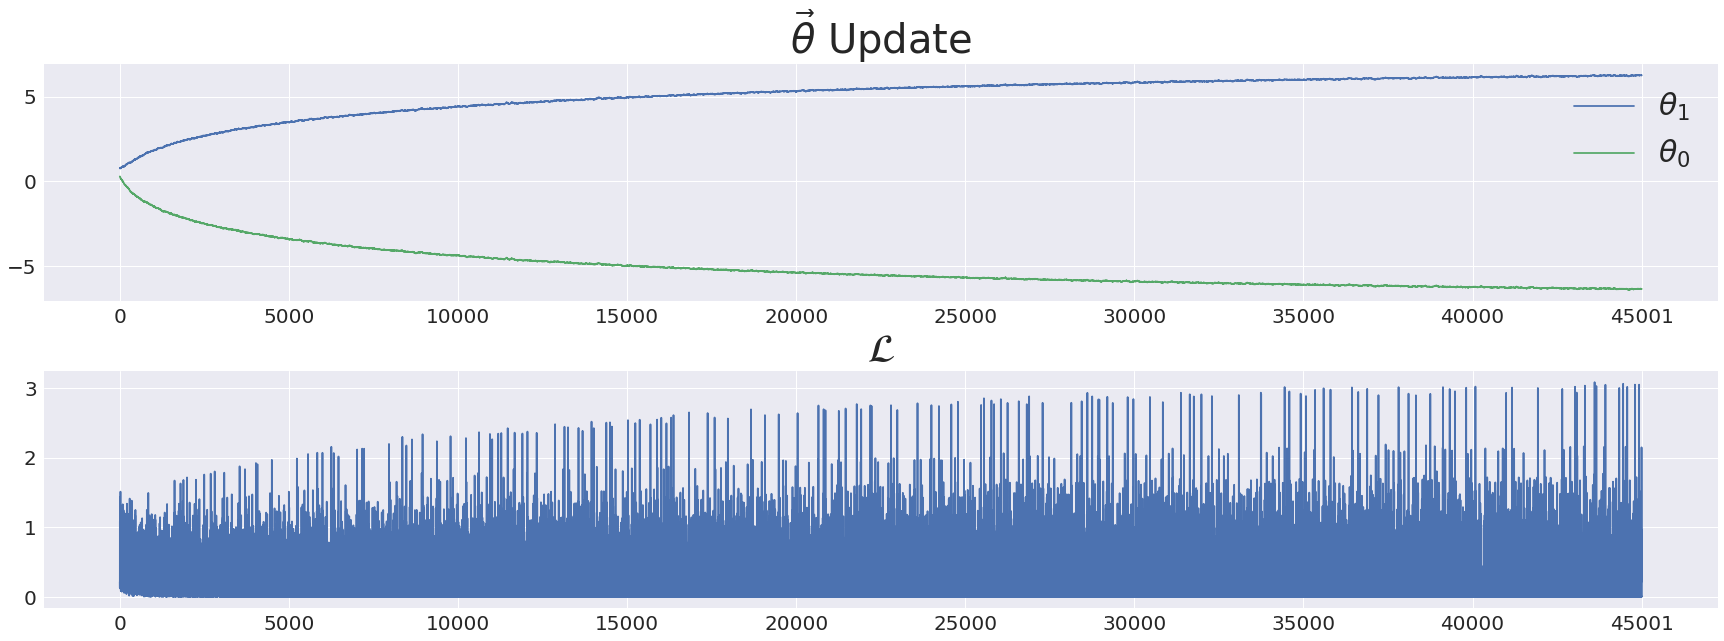

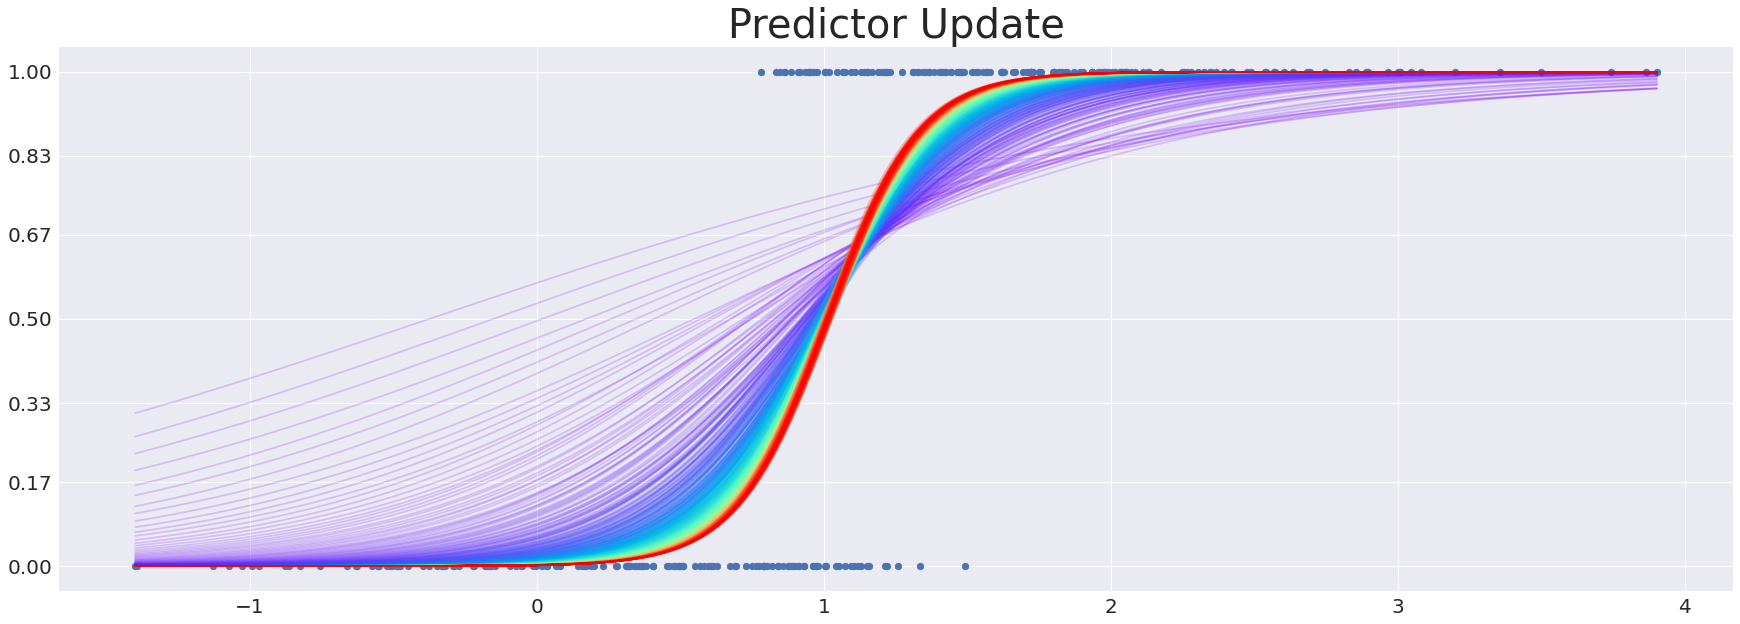

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class Affine:
    def __init__(self):
        self._feature_dim = 1
        self._Th = None
        
        self.node_imp()
        self.random_initialization()
        
    def node_imp(self):
        self._node1 = mul_node()
        self._node2 = plus_node()
        
    def random_initialization(self):
        r_feature_dim = np.sqrt(1/self._feature_dim)
        
        self._Th = np.random.uniform(low = -1*r_feature_dim,
                                     high = r_feature_dim,
                                     size = (self._feature_dim + 1,1))
        
    def forward(self, x):
        self._z1 = self._node1.forward(self._Th[1], x)
        self._z2 = self._node2.forward(self._Th[0], self._z1)
        
        return self._z2
    
    def backward(self, dz):
        dth0, dz1 = self._node2.backward(dz)
        dth1, dx = self._node1.backward(dz1)
        
        self._Th[1] = self._Th[1] - lr*dth1
        self._Th[0] = self._Th[0] - lr*dth0
        
    def get_Th(self):
        return self._Th
    
    
class Sigmoid:
    def __init__(self):
        self._pred = None
        
    def forward(self, z):
        self._pred = 1/(1 + np.exp(-1*z)) 
        return self._pred
    
    def backward(self, dpred):
        partial = self._pred*(1-self._pred)
        dz = dpred * partial
        return dz
    
    
class BinaryCrossEntropy_Loss:
    def __init__(self):
        self._y, self._pred = None, None
        
    def forward(self, y, pred):
        self._y, self._pred = y, pred
        loss = -1*(self._y*np.log(self._pred) + (1-self._y)*np.log(1-self._pred))
        return loss
   
    def backward(self):
        dpred = (self._pred - self._y) / (self._pred*(1-self._pred))
        return dpred
    
class SVLoR:
    def __init__(self):
        self._feature_dim = 1
        
        self._affine = Affine()
        self._sigmoid = Sigmoid()
        
    def forward(self, x):
        z = self._affine.forward(x)
        pred = self._sigmoid.forward(z)
        return pred
        
    def backward(self, dpred, lr):
        dz = self._sigmoid.backward(dpred)
        self._affine.backward(dz)
        
    def get_Th(self):
        return self._affine.get_Th()
    
def result_tracker():
    global iter_idx, check_freq
    global th_accum, model
    
    if iter_idx % check_freq == 0:
        th_accum = np.hstack((th_accum, model.get_Th()))
        loss_list.append(loss)
    iter_idx += 1
        
        
def result_visualizer():
    global th_accum, loss_list
    fig, ax = plt.subplots(2, 1, figsize = (30,10))
    fig.subplots_adjust(hspace = 0.3)
    ax[0].set_title(r'$\vec{\theta}$' + ' Update')
    
    ax[0].plot(th_accum[1,:], label = r'$\theta_{1}$')
    ax[0].plot(th_accum[0,:], label = r'$\theta_{0}$')
    
    ax[0].legend()
    iter_ticks = np.linspace(0,th_accum.shape[1],10).astype(np.int)
    ax[0].set_xticks(iter_ticks)
    
    ax[1].set_title(r'$\mathcal{L}$')
    ax[1].plot(loss_list)
    ax[1].set_xticks(iter_ticks)
    
    n_pred = 1000
    fig, ax = plt.subplots(figsize = (30,10))
    ax.set_title('Predictor Update')
    ax.scatter(data[:,1], data[:,-1])
    
    ax_idx_arr = np.linspace(0, len(loss_list)-1, n_pred).astype(np.int)
    cmap = cm.get_cmap('rainbow', lut = len(ax_idx_arr))
    
    x_pred = np.linspace(np.min(data[:,1]), np.max(data[:,1]), 1000)
    for ax_cnt, ax_idx in enumerate(ax_idx_arr):
        z = th_accum[1, ax_idx]*x_pred + th_accum[0, ax_idx]
        a = 1/(1 + np.exp(-1*z))
        ax.plot(x_pred, a,
                color = cmap(ax_cnt),
                alpha = 0.2)
        
    y_ticks = np.round(np.linspace(0, 1, 7),2)
    ax.set_yticks(y_ticks)
    
    
def dataset_generator(x_dict):

    x_data = np.random.normal(x_dict['mean'], x_dict['std'], x_dict['n_sample'])
    x_data_noise = x_data + x_dict['noise_factor']*np.random.normal(0,1,x_dict['n_sample'])
    
    if x_dict['direction'] > 0:
        y_data = (x_data_noise > x_dict['cutoff']).astype(np.int)
    else:
        y_data = (x_data_noise < x_dict['cutoff']).astype(np.int)
    
    data = np.zeros(shape = (x_dict['n_sample'],1))
    data = np.hstack((data, x_data.reshape(-1,1), y_data.reshape(-1,1)))

    return data
    
#---------------------------------------------------------------------

class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
#---------------------------------------------------------------------
plt.style.use('seaborn')
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 40
mpl.rcParams['legend.fontsize'] = 30

x_dict = {'mean':1, 'std':1, 'n_sample':300, 
          'noise_factor':0.3, 
          'cutoff':1, 'direction':1}

data = dataset_generator(x_dict)

model = SVLoR()
BCE_loss = BinaryCrossEntropy_Loss()

th_accum = model.get_Th()
loss_list = []

iter_idx, check_freq = 0, 2
epochs, lr = 300, 0.01

for epoch in range(epochs):
    np.random.shuffle(data)
    
    for data_idx in range(data.shape[0]):
        x, y = data[data_idx,1], data[data_idx, -1]
        
        pred = model.forward(x)
        loss = BCE_loss.forward(y, pred)
        
        dpred = BCE_loss.backward()
        model.backward(dpred, lr)
        
        result_tracker()

result_visualizer()
        
    